# Recurrent Neural Networks

- for times series data

- the probability at each step is dependent on all previous oberservations

     $P(y(t) | y(1), ..., y(t-1))$

- for practical reasons a fixed size window is chosen (e.g a sliding window)

- typically not very deeply stacked

# RNN and long term dependencies

- RNNs often tackle the problem of long term dependencies, data that is somehow related










In [1]:
# Generating the training data

import pandas as pd
import numpy as np

# 30 is the N : the number of input variables , the input vector

def generate_header() -> list:
     headers = []
     cols = [x for x in range(30)]
     label = "y"
     headers.extend(cols)
     headers.append(label)
     return headers

print(generate_header())

def generate_training_data(number_of_rows : int, N : int ) -> None:
     data = []
     data.append(generate_header())
     for x in range(number_of_rows):
          row = []
          series = generate_random_digit_vector(N)
          label_for_series = label(series)
          row.extend(series)
          row.append(label_for_series)
          data.append(row)
     

     df = pd.DataFrame(data)
     df.to_csv("lstmData.csv" , index=False, header=False)


def generate_random_digit_vector(N : int) -> np.ndarray:
     return np.random.choice(9, N)

def label(array : np.ndarray) -> int:
     if sum(array) >= 100:
          return 1
     else: 
          return 0

generate_training_data(10000, 30)





[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 'y']


In [11]:
# Building a recurrent Neural Network
import torch
import torch.nn as nn
from torch.utils.data import Dataset

"""
This class provides a custom dataset for the Dataloader for my Dataset
"""

class LSTMDataset(Dataset):

     def __init__(self, dataframe : pd.DataFrame, input_cols : list[str], label : str):
          super().__init__()
          self.dataframe = dataframe
          self.input_cols = input_cols
          self.label = label
     
     def __len__(self) -> int:
          return len(self.dataframe)

     def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
          row_series = self.dataframe.iloc[index]
          X = row_series[self.input_cols].astype(int).to_list()
          X_tensor = torch.tensor(X, dtype=torch.float32)

          Y = row_series[self.label].astype(int)
          Y_tensor = torch.tensor([Y], dtype=torch.float32)

          return X_tensor, Y_tensor




In [30]:

# The LSTM class

# 200 LSTM cells
# output vector h t is yielded at each timestep of the way
import torch
import torch.nn as nn
from typing import Callable
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F

class SimpleLSTM(nn.Module):

     def __init__(self , number_LSTM_cells : int, loss_function : Callable, network_activation : Callable):
          super().__init__()
          self.number_LSTM_cells = number_LSTM_cells
          self.layers = self._init_Layers()
          self.loss_function : Callable = loss_function
          self.network_activation : Callable = network_activation
     
     def _init_Layers(self) -> None:
          layers : nn.ModuleList = nn.ModuleList()
          layers.append(nn.LSTM(30, self.number_LSTM_cells))
          layers.append(nn.Linear(200, 1))
          print(len(layers))
          return layers

     # should give back a binary variable basically
     # input shape (10 = batch size, 30 = Sequence length)
     # output LSTM layer : (sequence lenght = 30 , batch size = 10, number of hidden LSTM cells = 200)
     def forward(self, input : torch.Tensor) -> torch.Tensor:
          hidden_states_for_all_timesteps, final_hidden_state_and_cell_state = self.layers[0](input)
          out_linear = self.layers[1](hidden_states_for_all_timesteps)
          return F.sigmoid(out_linear)
     
     def calculate_accuracy(self, predictions : torch.Tensor, actual : torch.Tensor) -> float:
          counter_acc = 0
          counter_general = len(predictions)

          assert len(predictions) == len(actual)

          for x in range(len(predictions)):
               # x is a tensor
               out_class = None
               if predictions[x] > 0.5:
                    out_class = 1
               else:
                    out_class = 0
               
               if out_class == actual[x]:
                    counter_acc += 1
          
          return counter_acc / counter_general
               

     def train(self, train_loader : DataLoader, iterations : int) -> tuple[list [float], list[float]]:

          optimizer = optim.Adam(self.parameters(), lr=0.001)
          errors = []
          accuracies = []
          iterations_counter = 0
          while iterations_counter < iterations:
                    for batch, labels in train_loader:
                         #print(f"Optimizing for batch with ID: {iterations_counter}")
                         optimizer.zero_grad()
                         out =  self.forward(batch)
                         loss = F.binary_cross_entropy(out, labels)
                         # just for vizualizing during training
                         if iterations_counter % 5 == 0:
                              accuracy = self.calculate_accuracy(out, labels)
                              accuracies.append(accuracy)
                              errors.append(loss.item())
                         loss.backward() 
                         optimizer.step()
                         iterations_counter += 1

          return errors, accuracies
     
     def test(self, test_loader : DataLoader) -> list[float]:
          self.eval()
          acc = []
          for batch , lables in test_loader:
               out = self.forward(batch)
               acc.append(self.calculate_accuracy(out, lables))
          
          return acc
               


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
2


C:\Users\jojog\AppData\Local\Temp\ipykernel_29056\3192806924.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = row_series[self.input_cols].astype(int).to_list()
C:\Users\jojog\AppData\Local\Temp\ipykernel_29056\3192806924.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = row_series[self.input_cols].astype(int).to_list()
C:\Users\jojog\AppData\Local\Temp\ipykernel_29056\3192806924.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

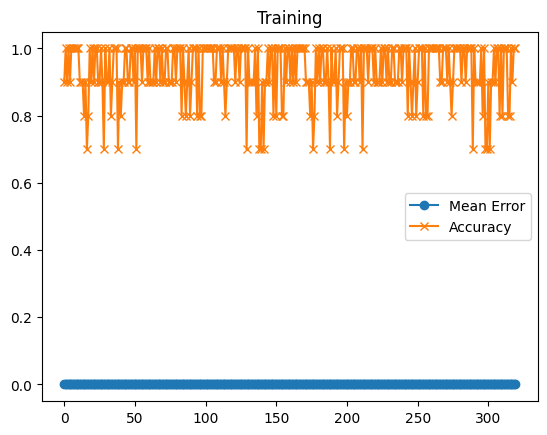

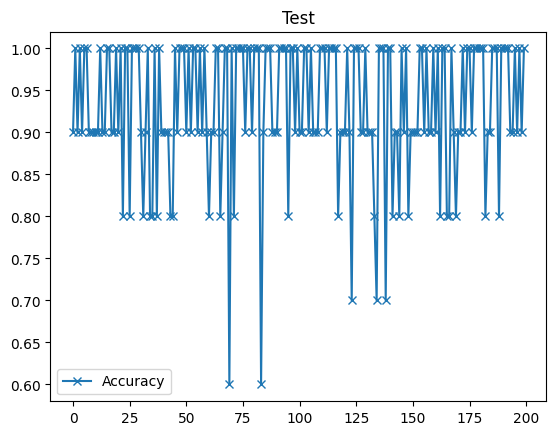

In [ ]:


import matplotlib.pyplot as plt


def vizualize_training_err_and_acc(err : list[float], acc : list[float]) -> None:
     x_axis = list(range(len(err)))
     plt.plot(x_axis, err, label='Mean Error', marker='o')
     plt.plot(x_axis, acc , label='Accuracy', marker='x' )
     plt.title("Training")
     plt.legend()
     plt.show()


def vizualize_test_err_and_acc(acc : list[float]) -> None:
     x_axis = list(range(len(acc)))
     #plt.plot(x_axis, err, label='Mean Error', marker='o')
     plt.plot(x_axis, acc , label='Accuracy', marker='x' )
     plt.title("Test")
     plt.legend()
     plt.show()



input_cols = np.arange(30)
print(input_cols)
last_data_set = LSTMDataset(pd.read_csv("lstmData.csv"), input_cols= input_cols, label="y")


train_size = int(0.8 * len(last_data_set)) 
test_size = len(last_data_set) - train_size
training_data, test_data = random_split(last_data_set, [train_size, test_size])

train_dataloader = DataLoader(training_data, 10, shuffle=False)
test_dataloader = DataLoader(test_data, 10, shuffle=False )

lstm_model = SimpleLSTM(200)

train_errors, train_acc = lstm_model.train(train_loader=train_dataloader, iterations=1000)

test_acc = lstm_model.test(test_loader=test_dataloader)

vizualize_training_err_and_acc(train_errors, train_acc)
vizualize_test_err_and_acc(test_acc)